In [16]:
import os
from collections import Counter
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [7]:
def create_concatenated_dataframe_in_current_folder():
    current_folder = os.getcwd()
    dataframes = []

    for author_idx, folder_name in enumerate(os.listdir(current_folder)):
        if folder_name.startswith('.'):
            continue
        folder_path = os.path.join(current_folder, folder_name)

        if os.path.isdir(folder_path):
            files_in_folder = os.listdir(folder_path)

            # Counter to enumerate texts within an author's folder
            text_counter = 1

            for file_name in files_in_folder:
                file_path = os.path.join(folder_path, file_name)
                if os.path.isfile(file_path) and file_name.endswith('.txt'):
                    with open(file_path, 'r', encoding='utf-8') as file:
                        text = file.read()
                    dataframes.append(pd.DataFrame({'author': [folder_name], 'text_index': [text_counter], 'text': [text]}))
                    text_counter += 1

    concatenated_df = pd.concat(dataframes, ignore_index=True)
    return concatenated_df

In [8]:
result_df = create_concatenated_dataframe_in_current_folder()

In [9]:
result_df

,author,text_index,text
0,navalny_jail,1,"Хорошо вам. Вы можете, не опасаясь, говорить о..."
1,navalny_jail,2,19 лет колонии особого режима. Цифра не имеет ...
2,navalny_jail,3,"Давно собирался написать об этом. Ну, пусть бу..."
3,pevchikh,1,"Судя по моему опросу в позапрошлом посте, мног..."
4,pevchikh,2,"День 14. Всегда всем говорю, что не скучаю по ..."
5,pevchikh,3,"Ну что, держите меня 36-летнюю. Получите, расп..."
6,volkov,1,"Привет, Денвер! У вас тут красиво. Но так труд..."
7,volkov,2,"Я никуда не пропал — возвращаюсь из Австралии,..."
8,volkov,3,В выходные в Штутгарте состоялась 58 церемония...
9,alburov,1,Сегодня у меня очень символичный день. Утром п...


In [10]:
def preprocess_text(text):
    # Preprocess the text (tokenization, lowercasing, etc.)
    # You might want to use more advanced preprocessing techniques here
    words = text.lower().split()
    return words

def calculate_term_frequencies(text):
    word_counts = Counter(text)
    total_words = len(text)
    term_frequencies = {word: count / total_words for word, count in word_counts.items()}
    return term_frequencies

def calculate_burrows_delta(text1, text2):
    preprocessed_text1 = preprocess_text(text1)
    preprocessed_text2 = preprocess_text(text2)

    term_frequencies1 = calculate_term_frequencies(preprocessed_text1)
    term_frequencies2 = calculate_term_frequencies(preprocessed_text2)

    # Combine unique terms from both texts
    all_terms = set(term_frequencies1.keys()) | set(term_frequencies2.keys())

    # Create vectors of term frequencies
    vector1 = np.array([term_frequencies1.get(term, 0) for term in all_terms])
    vector2 = np.array([term_frequencies2.get(term, 0) for term in all_terms])

    # Z-score normalization
    normalized_vector1 = zscore(vector1)
    normalized_vector2 = zscore(vector2)

    # Calculate Euclidean distance (Burrows' Delta score)
    delta_score = np.linalg.norm(normalized_vector1 - normalized_vector2)

    return delta_score

# Sample texts
text1 = "This is a sample text for testing."
text2 = "Another text used for testing purposes."

# Calculate Burrows' Delta score between the two texts
delta_score = calculate_burrows_delta(text1, text2)
print(f"Burrows' Delta score: {delta_score:.2f}")

Burrows' Delta score: 6.10


In [11]:
# Sample texts
text1 = "This is a sample text for testing."
text2 = "Another text used for testing purposes."

# Calculate Burrows' Delta score between the two texts
delta_score = calculate_burrows_delta(text1, text2)
print(f"Burrows' Delta score: {delta_score:.2f}")

Burrows' Delta score: 6.10


In [12]:
# Calculate Burrows' Delta for all pairs of texts within the same author, don't compare texts from different authors, show the results in a table, use the author's name + text index as the index of the table

# Create an empty list to store dataframes
burrows_dfs = []

# Iterate over all authors
for author in result_df['author'].unique():
    # Get all texts by the current author
    texts_by_author = result_df[result_df['author'] == author]

    # Create a list to store delta scores for the current author
    author_delta_scores = []

    # Iterate over all pairs of texts by the current author
    for text1_idx, text1 in texts_by_author.iterrows():
        for text2_idx, text2 in texts_by_author.iterrows():
            # Don't compare the same text
            if text1_idx == text2_idx:
                continue

            # Calculate Burrows' Delta score
            delta_score = calculate_burrows_delta(text1['text'], text2['text'])

            # Append the result to the list
            author_delta_scores.append({'author': author, 'text_index': f"{text1['text_index']}-{text2['text_index']}", 'delta_score': delta_score})

    # Create a dataframe for the current author's delta scores
    author_burrows_df = pd.DataFrame(author_delta_scores)

    # Append the author's dataframe to the list
    burrows_dfs.append(author_burrows_df)

# Concatenate all author dataframes
burrows_df = pd.concat(burrows_dfs, ignore_index=True)

In [13]:
burrows_df

,author,text_index,delta_score
0,navalny_jail,1-2,23.541232
1,navalny_jail,1-3,21.301128
2,navalny_jail,2-1,23.541232
3,navalny_jail,2-3,21.016255
4,navalny_jail,3-1,21.301128
5,navalny_jail,3-2,21.016255
6,pevchikh,1-2,22.823269
7,pevchikh,1-3,18.409751
8,pevchikh,2-1,22.823269
9,pevchikh,2-3,19.762567


In [14]:
# split text_index into two columns
burrows_df[['text_index1', 'text_index2']] = burrows_df['text_index'].str.split('-', expand=True)

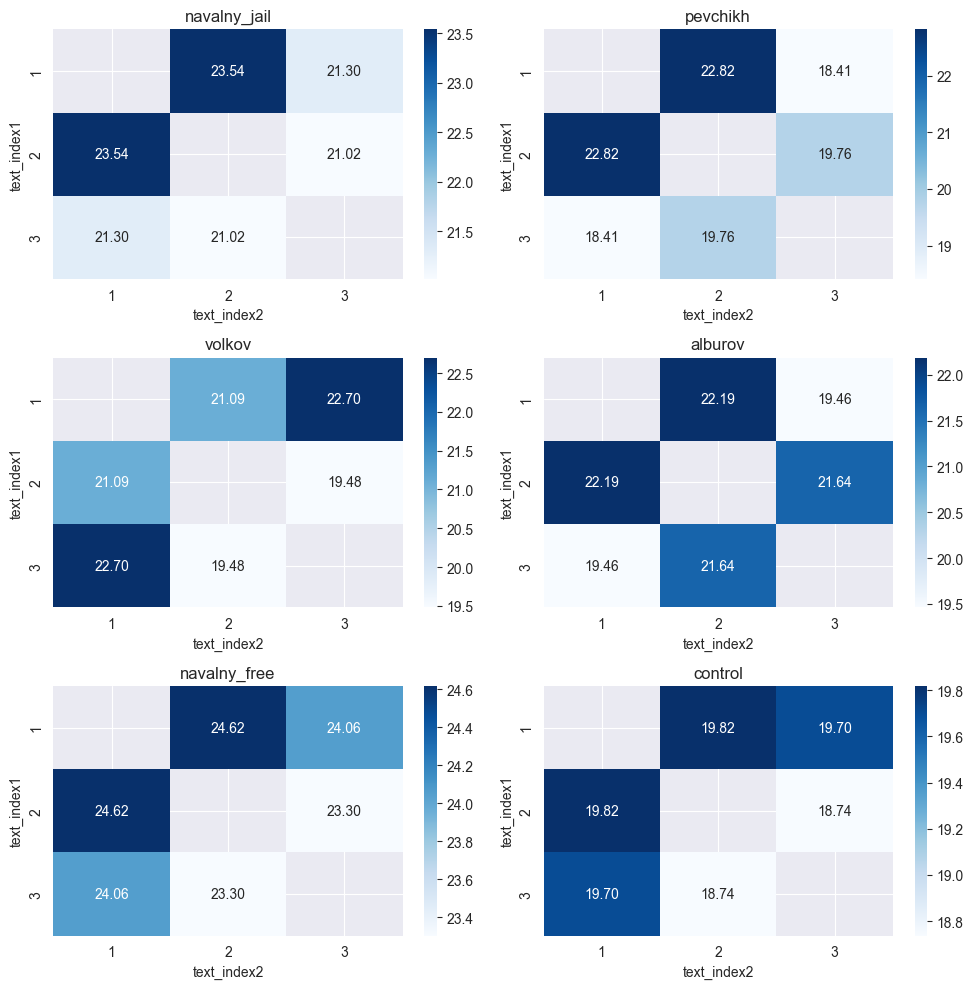

In [15]:
# Create a grid of plots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

# Get unique authors
unique_authors = burrows_df['author'].unique()

# Iterate over all authors
for author_idx, author in enumerate(unique_authors):
    # Get the current author's dataframe
    author_burrows_df = burrows_df[burrows_df['author'] == author]

    # Reset index before creating pivot table
    author_burrows_df_reset = author_burrows_df.reset_index(drop=True)

    # Create a pivot table from the reset dataframe
    pivot_table = author_burrows_df_reset.pivot(index='text_index1', columns='text_index2', values='delta_score')

    # Create a heatmap from the pivot table
    sns.heatmap(pivot_table, ax=axes[author_idx // 2, author_idx % 2], cmap='Blues', annot=True, fmt='.2f')

    # Set the title of the current plot
    axes[author_idx // 2, author_idx % 2].set_title(author)

# Adjust the layout of the plots
plt.tight_layout()

# Save the figure
plt.savefig('burrows_heatmap.png', dpi=300)

# Show the figure
plt.show()